# ALMA Data Example

Trey V. Wenger (c) December 2024

Here we test `bayes_cn_hfs` on some real ALMA data and demonstrate a general procedure for determining the carbon isotopic ratio from observations of CN and 13CN.

In [1]:
# General imports   
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.19.1
bayes_spec version: 1.7.2
bayes_cn_hfs version: 1.1.1+2.g81bbbdf.dirty


## Load the data

12CN 1021
13CN 1021


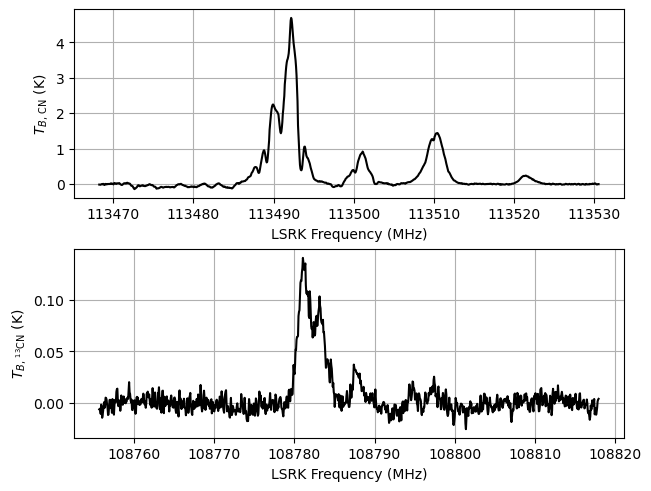

In [2]:
from bayes_spec import SpecData

data_12CN = np.genfromtxt("data_CN.tsv")
data_13CN = np.genfromtxt("data_13CN.tsv")

# estimate noise
noise_12CN = 1.4826 * np.median(np.abs(data_12CN[:, 0] - np.median(data_12CN[:, 0])))
noise_13CN = 1.4826 * np.median(np.abs(data_13CN[:, 0] - np.median(data_13CN[:, 0])))

obs_12CN = SpecData(
    1000.0 * data_12CN[:, 0],
    data_12CN[:, 1],
    noise_12CN,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_{B,\,\rm CN}$ (K)",
)
obs_13CN = SpecData(
    1000.0 * data_13CN[:, 0],
    data_13CN[:, 1],
    noise_13CN,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_{B,\,^{13}\rm CN}$ (K)",
)
data = {"12CN": obs_12CN, "13CN": obs_13CN}

for label, dataset in data.items():
    print(label, len(dataset.spectral))
    # HACK: normalize data by noise
    dataset._brightness_offset = np.median(dataset.brightness)
    dataset._brightness_scale = dataset.noise

# subset of 12CN data
data_12CN = {
    label: data[label]
    for label in data.keys() if "12CN" in label
}

# Plot the data
fig, axes = plt.subplots(2, layout="constrained")
axes[0].plot(data["12CN"].spectral, data["12CN"].brightness, 'k-')
axes[1].plot(data["13CN"].spectral, data["13CN"].brightness, 'k-')
axes[0].set_xlabel(data["12CN"].xlabel)
axes[1].set_xlabel(data["13CN"].xlabel)
axes[0].set_ylabel(data["12CN"].ylabel)
_ = axes[1].set_ylabel(data["13CN"].ylabel)

## Inspecting the CN data

Can we constrain the excitation temperature and optical depth? How about the hyperfine anomalies? It seems like there are two cloud components, so let's explore the data with that assumption for now. We assume make the weak LTE assumption such that the kinetic temperature is equal to the mean cloud excitation temperature. We are otherwise unable to constrain the kinetic temperature because non-thermal broadening is important and we have poor spectral resolution.

In [73]:
from bayes_cn_hfs.cn_model import CNModel
from bayes_cn_hfs import supplement_mol_data

mol_data_12CN, mol_weight_12CN = supplement_mol_data("CN")

n_clouds = 6
baseline_degree = 0
model = CNModel(
    data_12CN,
    molecule="CN", # molecule name
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff=1.0, # Main beam efficiency
    Feff=1.0, # Forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N = [14.0, 0.25], # mean and width of log10 total column density prior (cm-2)
    prior_log10_Tkin = None, # ignored because kinetic temperature is fixed
    prior_velocity = [-3.0, 5.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = False, # do not assume LTE
    prior_log10_Tex = [0.75, 0.1], # mean and width of excitation temperature prior (K)
    assume_CTEX = False, # do not assume CTEX
    prior_LTE_precision = 1000.0, # width of LTE precision prior
    fix_log10_Tkin = 1.5, # fix the kinetic temperature (K)
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

Sampling: [12CN, LTE_precision, baseline_12CN_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N_norm, log10_Tex_ul_norm, velocity_norm, weights]


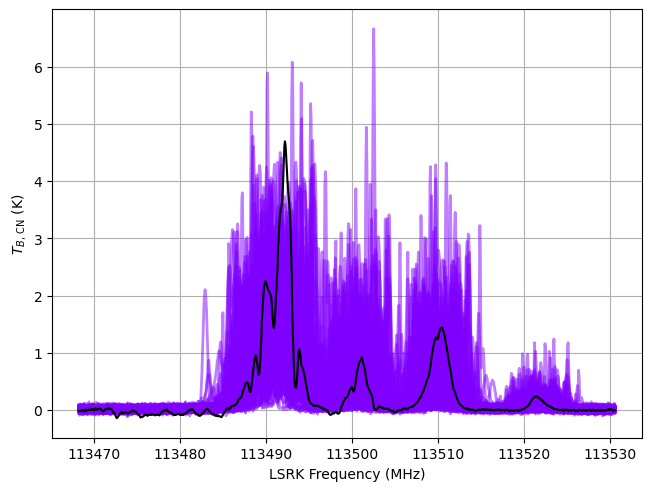

In [74]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

In [77]:
start = time.time()
model.fit(
    n = 20_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.05, # VI absolute convergence threshold
    learning_rate = 0.02, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Finished [100%]: Average Loss = 533.67


Output()

Runtime: 2.68 minutes


In [78]:
# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state"]))
]
pm.summary(model.trace.posterior, var_names=var_names + model.hyper_freeRVs + model.baseline_freeRVs)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
velocity[0],-2.841,0.020,-2.876,-2.804,0.001,0.000,872.0,907.0,NaN
velocity[1],-6.163,0.003,-6.169,-6.156,0.000,0.000,1221.0,944.0,NaN
velocity[2],-7.379,0.006,-7.391,-7.370,0.000,0.000,695.0,861.0,NaN
velocity[3],-4.291,0.005,-4.299,-4.282,0.000,0.000,1099.0,981.0,NaN
velocity[4],-2.317,0.004,-2.325,-2.311,0.000,0.000,999.0,832.0,NaN
velocity[5],-2.790,0.005,-2.799,-2.781,0.000,0.000,1007.0,919.0,NaN
fwhm_thermal[0],0.236,0.000,0.236,0.236,0.000,0.000,1000.0,1000.0,NaN
fwhm_thermal[1],0.236,0.000,0.236,0.236,0.000,0.000,1000.0,1000.0,NaN
fwhm_thermal[2],0.236,0.000,0.236,0.236,0.000,0.000,1000.0,1000.0,NaN
fwhm_thermal[3],0.236,0.000,0.236,0.236,0.000,0.000,1000.0,1000.0,NaN


Sampling: [12CN]


Output()

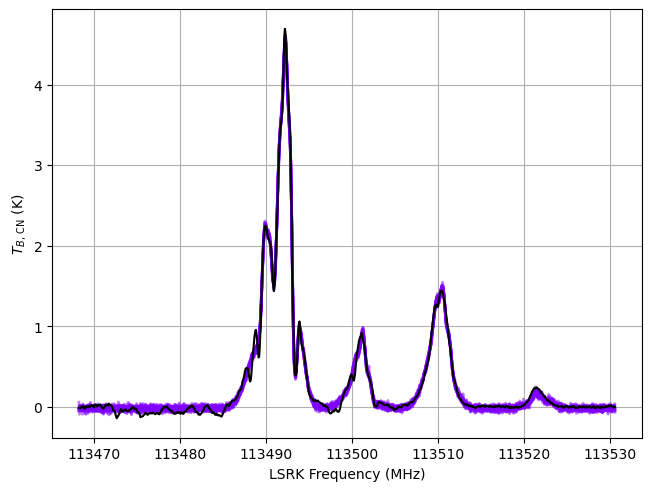

In [79]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## Number of cloud components

In [80]:
from bayes_spec import Optimize

max_n_clouds = 10
baseline_degree = 0
opt = Optimize(
    CNModel,
    data_12CN,
    molecule="CN", # molecule name
    mol_data=mol_data_12CN, # molecular data
    bg_temp = 2.7, # assumed background temperature (K)
    Beff=1.0, # Main beam efficiency
    Feff=1.0, # Forward efficiency
    max_n_clouds=max_n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
opt.add_priors(
    prior_log10_N = [14.0, 0.25], # mean and width of log10 total column density prior (cm-2)
    prior_log10_Tkin = None, # ignored because kinetic temperature is fixed
    prior_velocity = [-3.0, 5.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = 1.0, # width of latent Lorentzian FWHM prior (km/s) TIP: set to typical feature separation
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = False, # do not assume LTE
    prior_log10_Tex = [0.75, 0.1], # mean and width of excitation temperature prior (K)
    assume_CTEX = False, # do not assume CTEX
    prior_LTE_precision = 1000.0, # width of LTE precision prior
    fix_log10_Tkin = 1.5, # fix the kinetic temperature (K)
    ordered = False, # do not assume optically-thin
)
opt.add_likelihood()

Sampling: [12CN, LTE_precision, baseline_12CN_norm, fwhm_L_norm, fwhm_nonthermal_norm, log10_N_norm, log10_Tex_ul_norm, velocity_norm, weights]


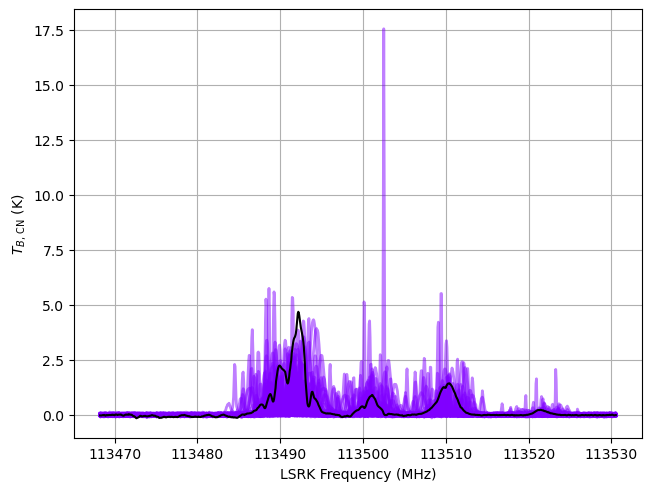

In [81]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = opt.models[1].sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(opt.models[1].data, prior.prior_predictive)

Approximate all models with variational inference.

In [82]:
start = time.time()
fit_kwargs = {
    "n": 20_000,
    "rel_tolerance": 0.01,
    "abs_tolerance": 0.05,
    "learning_rate": 0.02,
}
opt.fit_all(**fit_kwargs)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Null hypothesis BIC = 9.837e+05
Approximating n_cloud = 1 posterior...


Output()

Finished [100%]: Average Loss = 25,926


Output()

n_cloud = 1 BIC = 5.952e+04

Approximating n_cloud = 2 posterior...


Output()

Finished [100%]: Average Loss = 14,433


Output()

n_cloud = 2 BIC = 3.122e+04

Approximating n_cloud = 3 posterior...


Output()

Finished [100%]: Average Loss = 6,979.5


Output()

n_cloud = 3 BIC = 1.077e+04

Approximating n_cloud = 4 posterior...


Output()

Finished [100%]: Average Loss = 5,383.5


Output()

n_cloud = 4 BIC = 6.806e+03

Approximating n_cloud = 5 posterior...


Output()

Finished [100%]: Average Loss = 1,669.4


Output()

n_cloud = 5 BIC = 1.830e+03

Approximating n_cloud = 6 posterior...


Output()

Finished [100%]: Average Loss = 533.67


Output()

n_cloud = 6 BIC = -1.968e+00

Approximating n_cloud = 7 posterior...


Output()

Finished [100%]: Average Loss = 1,500.3


Output()

n_cloud = 7 BIC = 1.939e+03

Approximating n_cloud = 8 posterior...


Output()

Finished [100%]: Average Loss = 343.3


Output()

n_cloud = 8 BIC = -3.888e+02

Approximating n_cloud = 9 posterior...


Output()

Finished [100%]: Average Loss = -361.63


Output()

n_cloud = 9 BIC = -1.662e+03

Approximating n_cloud = 10 posterior...


Output()

Finished [100%]: Average Loss = -521.79


Output()

n_cloud = 10 BIC = -1.525e+03

Runtime: 25.33 minutes


[ 9.83688523e+05  5.95200559e+04  3.12208929e+04  1.07687710e+04
  6.80598056e+03  1.82960053e+03 -1.96767126e+00  1.93949664e+03
 -3.88770599e+02 -1.66173758e+03 -1.52473788e+03]


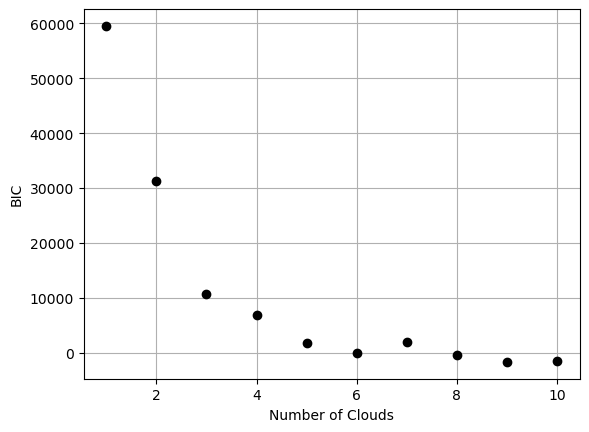

In [83]:
null_bic = opt.models[1].null_bic()
n_clouds = np.arange(max_n_clouds+1)
bics_vi = np.array([null_bic] + [model.bic(chain=0) for model in opt.models.values()])
print(bics_vi)

plt.plot(n_clouds[1:], bics_vi[1:], 'ko')
plt.xlabel("Number of Clouds")
_ = plt.ylabel("BIC")

The strange baseline structure makes it too difficult to identify the optimal number of clouds.